# Optimization Modeling Challenge


This challenge is design to evaluate your ability to translate physical and business requirements
into a mathematical optimization problem and express that problem in code.

This challenge deals with an idealized battery model. The goal of the challenge is to complete 
the battery model and write a cost function which can be used to optimize the battery's operation. 

In [1]:
#Imports
from typing import List
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from os import confstr

1. Review the sample code for the `SimpleBatteryModel`. 

Note that this is an idealized battery model with 100% efficiency. Complete the functions `max_capacity_limit()` and `min_capacity_limit()`.

In [ ]:
class SimpleBatteryModel:
    '''
    This class represents an idealized battery model
    and contains methods that define the battery's behavior and constraints.
    
    The __init__ method is the constructor method for the class. 
    It takes several parameters that define the battery's characteristics
    such as its capacity, discharge and charging limits, and the minimum 
    and maximum state of charge (SOC) values.
    '''
    def __init__(
        self,
        horizon: int = 144,                  # 12 hours
        control_interval_h: float = 1 / 12,  # 5 minute control intervals
        discharge_limit_kw: float = 500.0,
        charging_limit_kw: float = 500.0,

        # SOC related parameters
        capacity_kwh: float = 500.0,        # battery capacity in kWh
        soc_min: float = 0.2,                # minimum SOC
        soc_max: float = 0.8,                # maximum SOC
    ):
        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Optimization model parameters
        self.horizon = horizon
        self.control_interval_h = control_interval_h

        # Battery parameters
        self.discharge_limit_kw = -discharge_limit_kw
        self.charging_limit_kw = charging_limit_kw

        # State of charge parameters
        self.capacity_kwh = capacity_kwh
        self.soc_min = soc_min
        self.soc_max = soc_max

        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # power_kw is a variable which stores the power input/output of the battery
        # For this example, we consider that the battery is 100% efficient, so we don't need
        # to model charging and discharging separately.
        # In our model, charging is positive and discharging is negative.
        self.power_kw = cp.Variable((self.horizon,))


        # Define the CP. Variable related to the SOC of the Battery storage
        self.soc_kwh = cp.Variable((self.horizon,))


        # Define constraints
        self.constr = []
        self.constr += [self.discharge_power_limit(),
                        self.charging_power_limit(),
                        self.min_capacity_limit(),
                        self.max_capacity_limit(),
                        self.soc_update()]




    def discharge_power_limit(self) -> cp.Constraint:
        """Limit the discharge power of the battery."""
        return self.power_kw >= self.discharge_limit_kw

    def charging_power_limit(self) -> cp.Constraint:
        """Limit the charging power of the battery."""
        return self.power_kw <= self.charging_limit_kw

    def max_capacity_limit(self):
        """Limit the maximum energy stored in the battery to be less than its capacity."""
        # This function returns a constraint which limits the total energy stored in
        # the battery to less than the battery capacity at all times.
        # Here: self.soc_kwh is the CP variable,
        #       self.capacity_kwh is the total capacity of the battery
        #       self.soc_max is the maximum percentage of capacity for the battery
        
        return self.soc_kwh / self.capacity_kwh <= self.soc_max

    def min_capacity_limit(self):
        """Limit the energy stored in the battery to be greater than a minimum value."""
        # This function returns a constraint which limits the total energy stored in
        #       the battery to more than a minimum value at all times.
        # Here: self.soc_kwh is the CP variable,
        #       self.capacity_kwh is the total capacity of the battery
        #       self.soc_min is the minimum percentage of capacity for the battery
        return self.soc_kwh / self.capacity_kwh >= self.soc_min

    def soc_int(self):
        return [self.soc_kwh[0] >= self.soc_init_condition, 
                ]

    def soc_update(self):
        """Update the SOC of the battery based on the power input/output."""
        # Calculate the change in SOC from one time interval to the next
        #delta_soc[0] = self.soc_kwh[1:] - self.soc_init_condition 
        delta_soc = cp.diff(self.soc_kwh[1:])

        # Calculate the energy charged or discharged by the battery in each time interval
        energy = self.power_kw[:-1] * self.control_interval_h

        # Combine the SOC change and energy into a single vector equation
        return delta_soc == energy #THIS ARE EQUALLITY CONTRAINTS

    def constraints(self) -> List[cp.Constraint]:
        """Return list of constraints describing the battery model."""
        return self.constr

    def print_constraints(self):
      print(self.constr)
      return None


2. Complete the `net_cost()` function in `TimeOfUseTariff`. 

This cost function returns the cost (positive) or revenue (negative) of the site based on time varying cost vector. 

The site can earn revenue when it exports to the grid (i.e. the aggregate power draw is negative) or pays for electricity when it imports from the grid. 

Minimizing this cost is the objective of the optimization. You can assume that the cost vector is a numpy array where each element is the price for a particular interval in $/kWh. 

The price/revenue is the same for importing and exporting.

In [ ]:
class TimeOfUseTariff:
    """Model of a time-varying tariff"""

    def __init__(
        self,
        price_usd_kwh: np.ndarray,
        battery: SimpleBatteryModel,
        building_load_kw: np.ndarray,
        control_interval_h: float,
    ):
        self.price_usd_kwh = price_usd_kwh
        self.battery = battery
        self.building_load_kw = building_load_kw
        self.control_interval_h = control_interval_h

    def net_cost(self) -> cp.Expression:
        """Return the cost/revenue of the battery and building load."""

        '''
        In this implementation, we calculate the energy cost at each time interval as the product of
        the time-varying price vector, the sum of the building load and battery power output/input, 
        and the control interval time.
        The building load and battery power are summed because they represent the total power
        consumption or generation at each time interval.

        Note that we convert the power units from kW to kWh by multiplying by the control interval time
        (in hours). This is necessary because the time-varying price vector is defined in units of $/kWh.

        Finally, we sum the energy costs over the time horizon to obtain the total cost/revenue.
        '''

        # Calculate the energy cost at each time interval
        energy_cost = cp.multiply(self.price_usd_kwh, (self.building_load_kw + self.battery.power_kw) * self.control_interval_h)
        # Calculate the total cost/revenue
        total_cost = cp.sum(energy_cost)
        
        return total_cost


def plot(horizon: int, building_load: np.ndarray, battery: SimpleBatteryModel, price: np.ndarray):
    """Plot the results of the optimization."""
    fig, ax = plt.subplots( nrows=4,
                            ncols=1,
                            figsize=(5, 20),
                            layout='constrained',
                            dpi=300)
    x = np.arange(horizon)
    ax[0].step(x, building_load, label="Building Load")
    ax[0].step(x, battery.power_kw.value, label="Battery Power")
    ax[0].step(x, building_load + battery.power_kw.value, label="Net Load")
    ax[0].legend()
    ax[1].step(x, price, label="Price")
    ax[1].legend()
    ax[2].step(x, battery.soc_kwh.value, label = 'Battery capacity in KWh')
    ax[2].legend()
    ax[3].step(x, (battery.soc_kwh.value/battery.capacity_kwh), label = '% Battery capacity ')
    ax[3].legend()
    plt.show()

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 14 06:37:20 PM: Your problem has 288 variables, 5 constraints, and 0 parameters.
(CVXPY) May 14 06:37:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 06:37:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 14 06:37:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 14 06:37:20 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 14 06:37:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

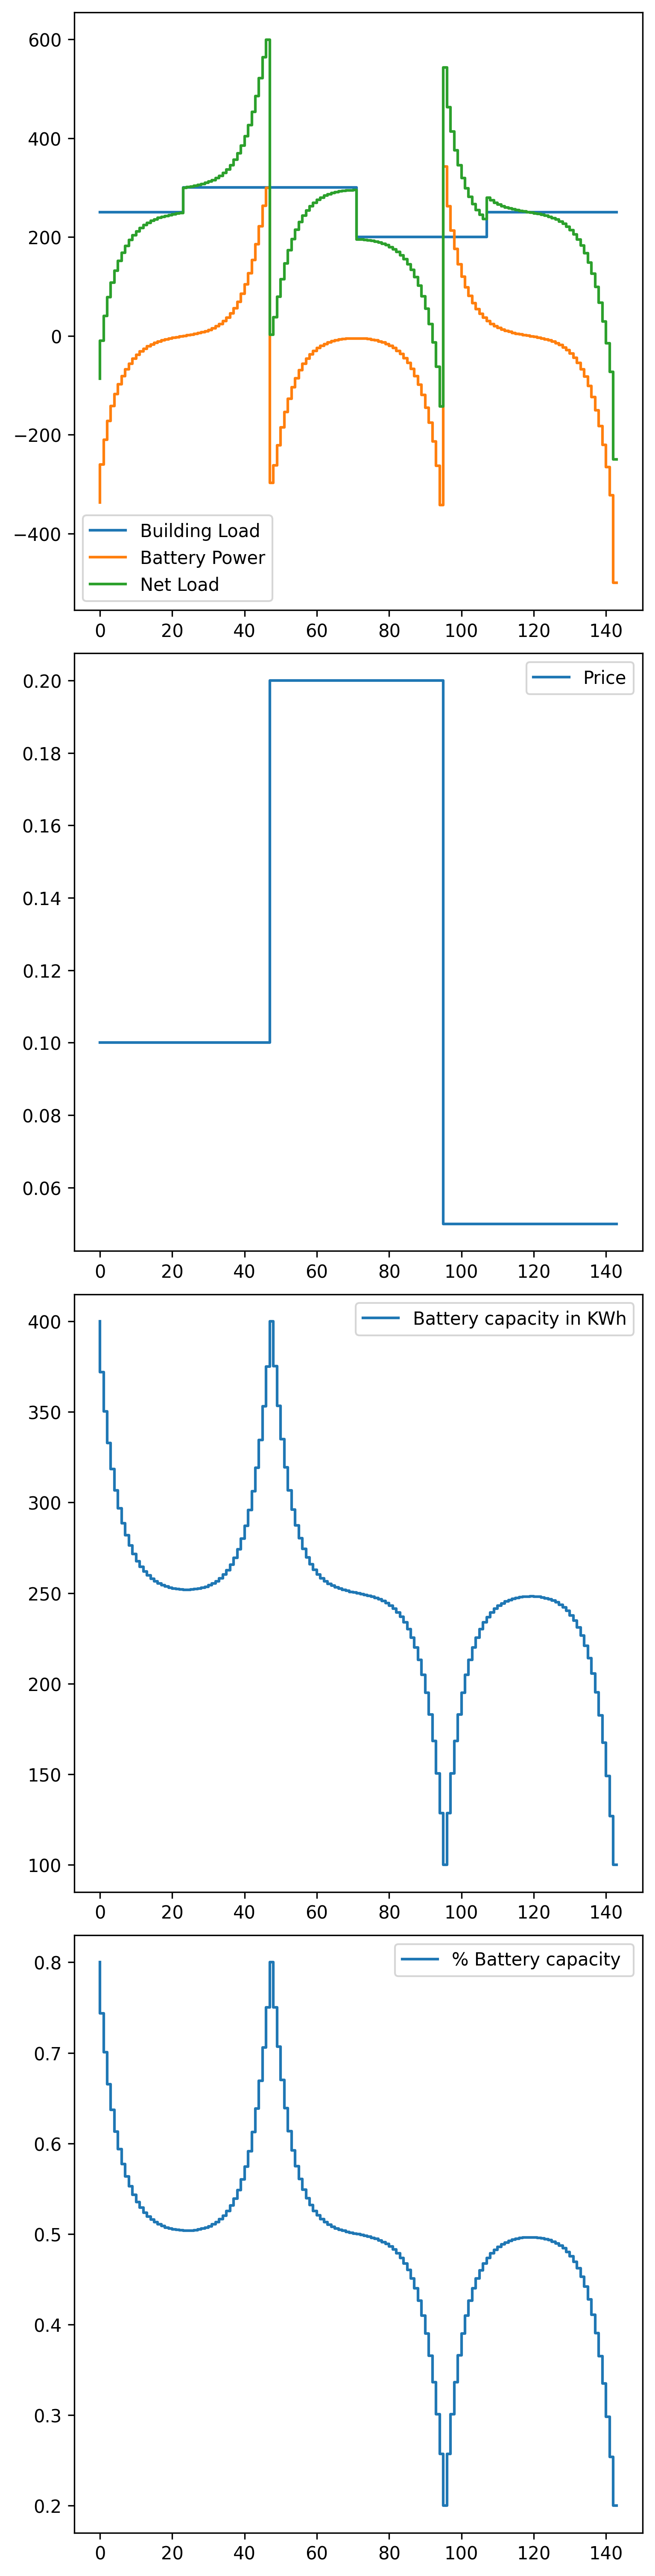

In [ ]:
# Define the time horizon and control interval for the battery model
opt_horizon = 144
opt_control_interval_h = 1 / 12

# Define the electricity price over the time horizon
price = np.array([0.1] * 48 + [0.2] * 48 + [0.05] * 48)

# Define the load profile of a building over the time horizon
building_load = np.array([250.0] * 24 + [300.0] * 48 + [200.0] * 36 + [250.0] * 36)

# Initialize an instance of the SimpleBatteryModel class with the specified parameters
battery = SimpleBatteryModel(
    horizon = opt_horizon,
    control_interval_h = opt_control_interval_h,
    capacity_kwh = 500
)

# Initialize an instance of the TimeOfUseTariff class to calculate the net cost of electricity
# for the building over the time horizon
tou_tariff = TimeOfUseTariff(price, battery, building_load, opt_control_interval_h)

# Calculate the net cost of electricity using the TimeOfUseTariff object
cost = tou_tariff.net_cost()

# Get a list of the constraints defined by the battery object
constraints = battery.constraints()

# Define an optimization problem to minimize the net cost of electricity subject to the constraints
problem = cp.Problem(objective=cp.Minimize(cost), constraints=constraints)

# Solve the optimization problem using the ECOS solver and print the optimal value of the objective function
problem.solve(verbose=True, solver="ECOS")
print(problem.value)

# Plot the battery operation over the time horizon
plot(opt_horizon, building_load, battery, price)




3. Extend the model for a hypothetical battery which considers overheating:
* When the battery charges or discharges the battery's temperature rises by 0.1 deg C / kWh. 
* The battery has a passive cooling system which is capable of reducing the battery's temperature by 1.0 deg C /   minute. 
* The cooling system cannot reduce the battery to a temperature below the ambient air temperature. 
* For simplicity, we will assume the cooling rate is independent of the  battery and ambient temperatures. 

Add constraint(s) so that the battery will not exceed 200 deg C at any time.

#### OPTION Nº1

This formulation uses the following approach:

* A strict restriction regarding the evolution of the Battery temperature.
* Use of the Big M formulation to deal with the absolute value nature of the temperature shift made by power flow.
* Considers that the temperature of the battery will always be above the ambient temperature.
Explanation: Since the cooling system cannot take the battery temperature   below the ambient temperature, it is not physically possible for the battery temperature to be lower than the ambient temperature. Therefore, it makes sense to constrain the battery temperature to be greater than or equal to the ambient temperature, rather than constraining it to be strictly greater than the ambient temperature.  This avoids the need to model the cooling system's behavior for temperatures below the ambient temperature and simplifies the overall model.


This Formulation is simple, however has a limitation.

The limitation is that if is the temperature change due to the power flow is too small. The problem turns unfeasible due to the assumption that the cooling system is always needed.

In [ ]:
class ExtendedBatteryModel:
    def __init__(
        self,
        horizon: int = 144,                  # 12 hours
        control_interval_h: float = 1 / 12,  # 5 minute control intervals
        discharge_limit_kw: float = 500.0,   # maximum discharge power in kW
        charging_limit_kw: float = 500.0,    # maximum charging power in kW

        # SOC related parameters
        capacity_kwh: float = 500.0,        # battery capacity in kWh
        soc_min: float = 0.2,                # minimum SOC
        soc_max: float = 0.8,                # maximum SOC

        # Temperature related parameters
        temperature_rise_C_kw : float = 0.1,    # 0.1 deg C / kWh  - temperature rise per unit power in deg C/kWh
        cooling_disipation_C_min: float = 1.0,  # 1.0 deg C /minute - cooling rate in deg C/min
        temperature_ambient : float = 25.0,     # 25.0 deg C - ambient temperature in deg C
        temperature_max : float = 200.0,        # 200.0 deg C - maximum allowable temperature in deg C
    ):
        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Optimization model parameters
        self.horizon = horizon
        self.control_interval_h = control_interval_h

        # Battery parameters
        self.discharge_limit_kw = -discharge_limit_kw
        self.charging_limit_kw = charging_limit_kw

        # State of charge parameters 
        self.capacity_kwh = capacity_kwh
        self.soc_min = soc_min
        self.soc_max = soc_max

        # Temperature related parameters
        self.temperature_rise_C_kw = temperature_rise_C_kw
        self.cooling_disipation_C_min = cooling_disipation_C_min
        self.temperature_ambient = temperature_ambient
        self.temperature_max = temperature_max


        # CONVEX FORMULATION RELATED VARIABLES
        #---------------------------------------
        # power_kw is a variable which stores the power input/output of the battery
        # For this example, we consider that the battery is 100% efficient, so we don't need
        # to model charging and discharging separately.
        # In our model, charging is positive and discharging is negative.
        self.power_kw = cp.Variable((self.horizon,))


        # Define the CP. Variable related to the SOC of the Battery storage
        self.soc_kwh = cp.Variable((self.horizon,))

        # Define the CP. Variable related to the temperature of the Battery storage
        self.temperature_C = cp.Variable((self.horizon,))

        # Define the CP. Variable related to implementation of the 
        # absolute value constraints using big-M formulation
        self.N = 100000  # choose a large value for N
        self.Y = cp.Variable((self.horizon-1,),boolean=True)

        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define constraints
        self.constr = []
        self.constr += [self.discharge_power_limit(),
                        self.charging_power_limit(),
                        self.min_capacity_limit(),
                        self.max_capacity_limit(),
                        self.soc_update(),
                        self.min_temperature_limit(),
                        self.max_temperature_limit()]

        # Constraints related to the temperature update
        self.Big_M_contraints = []
        self.Big_M_contraints = self.temperature_update()
        # Add the temperature constraints to the overall list of constraints
        for constraint in self.Big_M_contraints:
          self.constr += [constraint]




    def discharge_power_limit(self) -> cp.Constraint:
        """Limit the discharge power of the battery."""
        return self.power_kw >= self.discharge_limit_kw

    def charging_power_limit(self) -> cp.Constraint:
        """Limit the charging power of the battery."""
        return self.power_kw <= self.charging_limit_kw

    def max_capacity_limit(self):
        """Limit the maximum energy stored in the battery to be less than its capacity."""
        # This function returns a constraint which limits the total energy stored in
        # the battery to less than the battery capacity at all times.
        # Here: self.soc_kwh is the CP variable,
        #       self.capacity_kwh is the total capacity of the battery
        #       self.soc_max is the maximum percentage of capacity for the battery
        return self.soc_kwh / self.capacity_kwh <= self.soc_max

    def min_capacity_limit(self):
        """Limit the energy stored in the battery to be greater than a minimum value."""
        # This function returns a constraint which limits the total energy stored in
        #       the battery to more than a minimum value at all times.
        # Here: self.soc_kwh is the CP variable,
        #       self.capacity_kwh is the total capacity of the battery
        #       self.soc_min is the minimum percentage of capacity for the battery
        return self.soc_kwh / self.capacity_kwh >= self.soc_min

    def soc_update(self):
        """Update the SOC of the battery based on the power input/output."""
        #As Soc is stored as KWh variable, the energy charged or discharged by power_kw 
        #from one sample to the following one should be expressed in  KWh.
        #And from one sample to the following one there is a delta t of 5 minutes or 1/12 hours
        
        # Calculate the change in SOC from one time interval to the next
        delta_soc = cp.diff(self.soc_kwh)

        # Calculate the energy charged or discharged by the battery in each time interval
        energy = self.power_kw[:-1] * self.control_interval_h

        # Combine the SOC change and energy into a single vector equation
        return delta_soc == energy  # THIS ARE EQUALLITY CONTRAINTS

    def max_temperature_limit(self):
        """
        Limit the maximum battery temperature to be 
        less than or equal to the maximum allowable temperature.
        """
        return self.temperature_C <= self.temperature_max

    def min_temperature_limit(self):
        """
        Limit the minimum battery temperature to be 
        greater than or equal to the ambient temperature.
        """
        '''
        NOTE:Since the cooling system cannot take the battery temperature
        below the ambient temperature, it is not physically possible
        for the battery temperature to be lower than the ambient temperature.
        Therefore, it makes sense to constrain the battery temperature to be
        greater than or equal to the ambient temperature, 
        rather than constraining it to be strictly greater than 
        the ambient temperature. 
        This avoids the need to model the cooling system's behavior
        for temperatures below the ambient temperature and simplifies
        the overall model.
        '''
        return self.temperature_C >= self.temperature_ambient

    def temperature_update(self):
        """
        Calculate the temperature change in each time interval.

        This must be the difference between:
        * (absolute value of self.power *  self.temperature_rise_C_kw)
        * (self.cooling_disipation_C_min * 60 * self.control_interval_h )
        """
        # Calculate the change Battery´s temperature from one time interval to the next
        temperature_delta = cp.diff(self.temperature_C)

        # Calculate the temperature change due to cooling in each time interval
        temperature_change_cooling = self.cooling_disipation_C_min * 60 * self.control_interval_h


        # Calculate the temperature change due to power flow in each time interval
        # NOTE THAT: temperature_change_power should be ALWAYS positive.
        # To Handle this condition, we cannnot use ABS() because that turns the problem non-convex.
        # So, we have to use another trick to model that condition.
        temperature_change_power = (self.power_kw[:-1]) * self.temperature_rise_C_kw * self.control_interval_h

        # Implement the absolute value constraints using big-M formulation
        constraints = [
            temperature_change_power <= temperature_delta + temperature_change_cooling,
            -temperature_change_power <= temperature_delta + temperature_change_cooling,
            temperature_change_power + self.N * self.Y >= temperature_delta + temperature_change_cooling,
            -temperature_change_power + self.N * (1 - self.Y) >= temperature_delta + temperature_change_cooling      
            ]

        return constraints 

    def constraints(self) -> List[cp.Constraint]:
        """Return list of constraints describing the battery model."""
        return self.constr

    def print_constraints(self):
      print(self.constr)
      return None

In [ ]:
# ExtendedBatteryModel inheriting from SimpleBattert model

class ExtendedBatteryModel(SimpleBatteryModel):
    def __init__(
        self,
        horizon: int = 144,
        control_interval_h: float = 1 / 12,
        discharge_limit_kw: float = 500.0,
        charging_limit_kw: float = 500.0,
        capacity_kwh: float = 500.0,
        soc_min: float = 0.2,
        soc_max: float = 0.8,
        temperature_rise_C_kw: float = 0.1,
        cooling_disipation_C_min: float = 1.0,
        temperature_ambient: float = 25.0,
        temperature_max: float = 200.0
    ):
        # Call the __init__ method of the SimpleBatteryModel class to initialize
        # the optimization model parameters and battery parameters
        super().__init__(
            horizon=horizon,
            control_interval_h=control_interval_h,
            capacity_kwh=capacity_kwh,
            discharge_limit_kw = discharge_limit_kw,
            charging_limit_kw = charging_limit_kw,
            soc_min = soc_min,
            soc_max = soc_max
        )
        
        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Add the new parameters to the object
        self.temperature_rise_C_kw = temperature_rise_C_kw
        self.cooling_disipation_C_min = cooling_disipation_C_min
        self.temperature_ambient = temperature_ambient
        self.temperature_max = temperature_max

        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define the CP. Variable related to implementation of the 
        # absolute value constraints using big-M formulation
        self.temperature_C = cp.Variable((self.horizon,))
        self.N = 100000
        self.Y = cp.Variable((self.horizon - 1,), boolean=True)

        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define constraints
        self.constr += [
            self.min_temperature_limit(),
            self.max_temperature_limit()
        ]

        # Constraints related to the temperature update
        self.Big_M_contraints = []
        self.Big_M_contraints = self.temperature_update()
        # Add the temperature constraints to the overall list of constraints
        for constraint in self.Big_M_contraints:
            self.constr += [constraint]

    def max_temperature_limit(self):
        """
        Limit the maximum battery temperature to be
        less than or equal to the maximum allowable temperature.
        """
        return self.temperature_C <= self.temperature_max

    def min_temperature_limit(self):
        """
        Limit the minimum battery temperature to be
        greater than or equal to the ambient temperature.
        """
        return self.temperature_C >= self.temperature_ambient

    def temperature_update(self):
        """
        Calculate the temperature change in each time interval.

        This must be the difference between:
        * (absolute value of self.power *  self.temperature_rise_C_kw)
        * (self.cooling_disipation_C_min * 60 * self.control_interval_h )
        """
        # Calculate the change Battery´s temperature from one time interval to the next
        temperature_delta = cp.diff(self.temperature_C)

        # Calculate the temperature change due to cooling in each time interval
        temperature_change_cooling = self.cooling_disipation_C_min * 60 * self.control_interval_h


        # Calculate the temperature change due to power flow in each time interval
        # NOTE THAT: temperature_change_power should be ALWAYS positive.
        # To Handle this condition, we cannnot use ABS() because that turns the problem non-convex.
        # So, we have to use another trick to model that condition.
        temperature_change_power = (self.power_kw[:-1]) * self.temperature_rise_C_kw * self.control_interval_h

        # Implement the absolute value constraints using big-M formulation
        constraints = [
            temperature_change_power <= temperature_delta + temperature_change_cooling,
            -temperature_change_power <= temperature_delta + temperature_change_cooling,
            temperature_change_power + self.N * self.Y >= temperature_delta + temperature_change_cooling,
            -temperature_change_power + self.N * (1 - self.Y) >= temperature_delta + temperature_change_cooling
        ]
        return constraints

var2461[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) <= var2498[1:144] + -var2498[0:143] + Promote(5.0, (143,))
-var2461[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) <= var2498[1:144] + -var2498[0:143] + Promote(5.0, (143,))
var2498[1:144] + -var2498[0:143] + Promote(5.0, (143,)) <= var2461[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) + Promote(100000.0, (143,)) @ var2499
var2498[1:144] + -var2498[0:143] + Promote(5.0, (143,)) <= -var2461[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) + Promote(100000.0, (143,)) @ (Promote(1.0, (143,)) + -var2499)
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 14 08:13:48 PM: Your problem has 575 variables, 11 constraints, and 0 parameters.
(CVXPY) May 14 08:13:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 

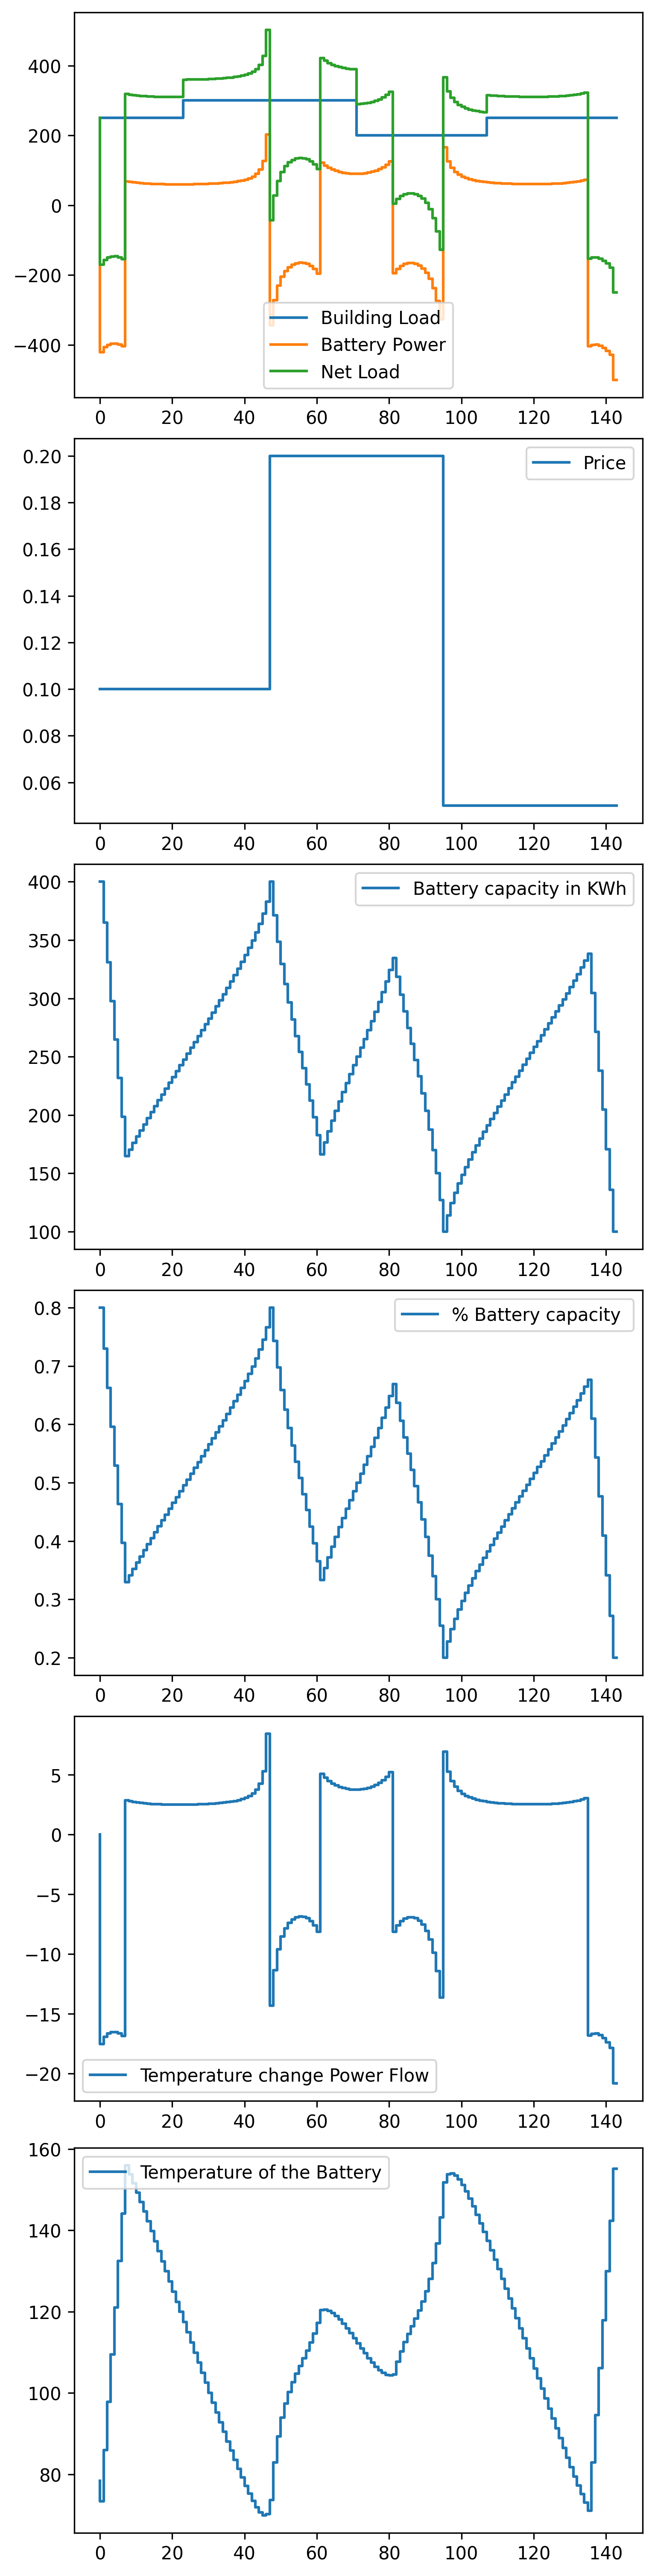

In [ ]:
# Define the time horizon and control interval for the battery model
opt_horizon = 144
opt_control_interval_h = 1 / 12

# Define the electricity price over the time horizon
price = np.array([0.1] * 48 + [0.2] * 48 + [0.05] * 48)

# Define the load profile of a building over the time horizon
building_load = np.array([250.0] * 24 + [300.0] * 48 + [200.0] * 36 + [250.0] * 36)

# Initialize an instance of the SimpleBatteryModel class with the specified parameters
batteryEX = ExtendedBatteryModel( horizon = opt_horizon,
                                control_interval_h = opt_control_interval_h,
                                discharge_limit_kw = 500.0,
                                charging_limit_kw = 500.0,
                                capacity_kwh = 500.0,        # battery capacity in kWh
                                soc_min = 0.2,                # minimum SOC
                                soc_max = 0.8,                # maximum SOC
                                temperature_rise_C_kw  = 0.5,  # 0.5 deg C / kWh
                                cooling_disipation_C_min = 1.0,  # 1.0 deg C /minute
                                temperature_ambient = 25.0,     # 25.0 deg C
                                temperature_max  = 200.0        # 200.0 deg C
                            )


# Initialize an instance of the TimeOfUseTariff class to calculate the net cost of electricity
# for the building over the time horizon
tou_tariff = TimeOfUseTariff(price, batteryEX, building_load, opt_control_interval_h)
# Calculate the net cost of electricity using the TimeOfUseTariff object
cost = tou_tariff.net_cost()

# Get a list of the constraints defined by the battery object
constraints = batteryEX.constraints()

# Define an optimization problem to minimize the net cost of electricity subject to the constraints
problem = cp.Problem(objective=cp.Minimize(cost), constraints=constraints)

# Solve the optimization problem using the ECOS solver and print the optimal value of the objective function
problem.solve(verbose=True, solver="ECOS_BB")
print(problem.value)

# Plot the battery operation over the time horizon
plot(opt_horizon, building_load, batteryEX, price)


#### OPTION Nº2

This formulation relax the evolution of the temperature of the Battery to be greater than the difference between of the Temperature change given by the power flow and the cooling system.

The temperature of the Battery has better values in the optimal solution. However, this formulation has the same limitation as Option N°1.

In [ ]:
# Full version
class ExtendedBatteryModel:
    def __init__(
        self,
        horizon: int = 144,                  # 12 hours
        control_interval_h: float = 1 / 12,  # 5 minute control intervals
        discharge_limit_kw: float = 500.0,
        charging_limit_kw: float = 500.0,

        # SOC related parameters
        capacity_kwh: float = 500.0,        # battery capacity in kWh
        soc_min: float = 0.2,                # minimum SOC
        soc_max: float = 0.8,                # maximum SOC

        # Temperature related parameters
        temperature_rise_C_kw : float = 0.1,  # 0.1 deg C / kWh
        cooling_disipation_C_min: float = 1.0,  # 1.0 deg C /minute
        temperature_ambient : float = 25.0,     # 25.0 deg C
        temperature_max : float = 200.0,        # 200.0 deg C
    ):
        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Optimization model parameters
        self.horizon = horizon
        self.control_interval_h = control_interval_h

        # Battery parameters
        self.discharge_limit_kw = -discharge_limit_kw
        self.charging_limit_kw = charging_limit_kw

        # State of charge parameters 
        self.capacity_kwh = capacity_kwh
        self.soc_min = soc_min
        self.soc_max = soc_max

        # Temperature related parameters
        self.temperature_rise_C_kw = temperature_rise_C_kw
        self.cooling_disipation_C_min = cooling_disipation_C_min
        self.temperature_ambient = temperature_ambient
        self.temperature_max = temperature_max


        # CONVEX FORMULATION RELATED VARIABLES
        #---------------------------------------
        # power_kw is a variable which stores the power input/output of the battery
        # For this example, we consider that the battery is 100% efficient, so we don't need
        # to model charging and discharging separately.
        # In our model, charging is positive and discharging is negative.
        self.power_kw = cp.Variable((self.horizon,))


        # Define the CP. Variable related to the SOC of the Battery storage
        self.soc_kwh = cp.Variable((self.horizon,))

        # Define the CP. Variable related to the temperature of the Battery storage
        self.temperature_C = cp.Variable((self.horizon,))

        # Define the CP. Variable related to implementation of the 
        # absolute value constraints using big-M formulation
        self.N = 100000  # choose a large value for N
        self.Y = cp.Variable((self.horizon-1,),boolean=True)
        self.cooling_on = cp.Variable((self.horizon - 1,), boolean=True)

        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define constraints
        self.constr = []
        self.constr += [self.discharge_power_limit(),
                        self.charging_power_limit(),
                        self.min_capacity_limit(),
                        self.max_capacity_limit(),
                        self.soc_update(),
                        self.min_temperature_limit(),
                        self.max_temperature_limit()]

        self.Big_M_contraints = []
        self.Big_M_contraints = self.temperature_update()

        for constraint in self.Big_M_contraints:
          self.constr += [constraint]




    def discharge_power_limit(self) -> cp.Constraint:
        """Limit the discharge power of the battery."""
        return self.power_kw >= self.discharge_limit_kw

    def charging_power_limit(self) -> cp.Constraint:
        """Limit the charging power of the battery."""
        return self.power_kw <= self.charging_limit_kw

    def max_capacity_limit(self):
        """Limit the maximum energy stored in the battery to be less than its capacity."""
        # TODO: This function should return a constraint which limits the total energy stored in
        #       the battery to less than the battery capacity at all times.
        return self.soc_kwh / self.capacity_kwh <= self.soc_max

    def min_capacity_limit(self):
        """Limit the energy stored in the battery to be greater than a minimum value."""
        # TODO: This function should return a constraint which limits the total energy stored in
        #       the battery to more than a minimum value at all times.
        return self.soc_kwh / self.capacity_kwh >= self.soc_min

    def soc_update(self):
        """Update the SOC of the battery based on the power input/output."""
        #As Soc is stored as KWh variable, the energy charged or discharged by power_kw 
        #from one sample to the following one should be expressed in  KWh.
        #And from one sample to the following one there is a delta t of 5 minutes or 1/12 hours
        
        # Calculate the change in SOC from one time interval to the next
        delta_soc = cp.diff(self.soc_kwh)

        # Calculate the energy charged or discharged by the battery in each time interval
        energy = self.power_kw[:-1] * self.control_interval_h

        # Combine the SOC change and energy into a single vector equation
        return delta_soc == energy  # THIS ARE EQUALLITY CONTRAINTS

    def max_temperature_limit(self):
        """
        Limit the maximum battery temperature to be 
        less than or equal to the maximum allowable temperature.
        """
        return self.temperature_C <= self.temperature_max

    def min_temperature_limit(self):
        """
        Limit the minimum battery temperature to be 
        greater than or equal to the ambient temperature.
        """
        '''
        NOTE:Since the cooling system cannot take the battery temperature
        below the ambient temperature, it is not physically possible
        for the battery temperature to be lower than the ambient temperature.
        Therefore, it makes sense to constrain the battery temperature to be
        greater than or equal to the ambient temperature, 
        rather than constraining it to be strictly greater than 
        the ambient temperature. 
        This avoids the need to model the cooling system's behavior
        for temperatures below the ambient temperature and simplifies
        the overall model.
        '''
        return self.temperature_C >= self.temperature_ambient

    def temperature_update(self):
        """
        '''
        Calculate the temperature change in each time interval

        This must be the difference between:
              (absolute value of self.power *  self.temperature_rise_C_kw)
              (self.cooling_disipation_C_min * 60 * self.control_interval_h )
         '''
        """
        # Calculate the change Battery´s temperature from one time interval to the next
        temperature_delta = cp.diff(self.temperature_C)

        # Calculate the temperature change due to cooling in each time interval
        temperature_change_cooling = self.cooling_disipation_C_min * 60 * self.control_interval_h

        
        # Calculate the temperature change due to power flow in each time interval
        # NOTE THAT: temperature_change_power should be ALWAYS positive.
        # To Handle this condition, we cannnot use ABS() because that turns the problem non-convex.
        # So, we have to use another trick to model that condition.
        temperature_change_power = (self.power_kw[:-1]) * self.temperature_rise_C_kw * self.control_interval_h

        # Implement the absolute value constraints using big-M formulation
        constraints = [
             temperature_change_power + self.N * self.Y >= temperature_delta + temperature_change_cooling,
            -temperature_change_power + self.N * (1 - self.Y) >= temperature_delta + temperature_change_cooling,
            ]

        return constraints 

    def constraints(self) -> List[cp.Constraint]:
        """Return list of constraints describing the battery model."""
        return self.constr

    def print_constraints(self):
      print(self.constr)
      return None

In [ ]:
# ExtendedBatteryModel inheriting from SimpleBattert model
class ExtendedBatteryModel(SimpleBatteryModel):
    def __init__(
        self,
        horizon: int = 144,
        control_interval_h: float = 1 / 12,
        discharge_limit_kw: float = 500.0,
        charging_limit_kw: float = 500.0,
        capacity_kwh: float = 500.0,
        soc_min: float = 0.2,
        soc_max: float = 0.8,
        temperature_rise_C_kw: float = 0.1,
        cooling_disipation_C_min: float = 1.0,
        temperature_ambient: float = 25.0,
        temperature_max: float = 200.0
    ):
        # Call the __init__ method of the SimpleBatteryModel class to initialize
        # the optimization model parameters and battery parameters
        super().__init__(
            horizon=horizon,
            control_interval_h=control_interval_h,
            capacity_kwh=capacity_kwh,
            discharge_limit_kw = discharge_limit_kw,
            charging_limit_kw = charging_limit_kw,
            soc_min = soc_min,
            soc_max = soc_max
        )
        
        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Temperature related parameters
        self.temperature_rise_C_kw = temperature_rise_C_kw
        self.cooling_disipation_C_min = cooling_disipation_C_min
        self.temperature_ambient = temperature_ambient
        self.temperature_max = temperature_max


        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Define the CP. Variable related to the temperature of the Battery storage
        self.temperature_C = cp.Variable((self.horizon,))

        # Define the CP. Variable related to implementation of the 
        # absolute value constraints using big-M formulation
        self.N = 100000  # choose a large value for N
        self.Y = cp.Variable((self.horizon-1,),boolean=True)
        self.cooling_on = cp.Variable((self.horizon - 1,), boolean=True)

        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define constraints
        self.constr += [self.min_temperature_limit(),
                        self.max_temperature_limit()]

        self.Big_M_contraints = []
        self.Big_M_contraints = self.temperature_update()

        for constraint in self.Big_M_contraints:
          self.constr += [constraint]


    def max_temperature_limit(self):
        """
        Limit the maximum battery temperature to be 
        less than or equal to the maximum allowable temperature.
        """
        return self.temperature_C <= self.temperature_max

    def min_temperature_limit(self):
        """
        Limit the minimum battery temperature to be 
        greater than or equal to the ambient temperature.
        """
        '''
        NOTE:Since the cooling system cannot take the battery temperature
        below the ambient temperature, it is not physically possible
        for the battery temperature to be lower than the ambient temperature.
        Therefore, it makes sense to constrain the battery temperature to be
        greater than or equal to the ambient temperature, 
        rather than constraining it to be strictly greater than 
        the ambient temperature. 
        This avoids the need to model the cooling system's behavior
        for temperatures below the ambient temperature and simplifies
        the overall model.
        '''
        return self.temperature_C >= self.temperature_ambient

    def temperature_update(self):
        """
        '''
        Calculate the temperature change in each time interval

        This must be the difference between:
              (absolute value of self.power *  self.temperature_rise_C_kw)
              (self.cooling_disipation_C_min * 60 * self.control_interval_h )
         '''
        """
        # Calculate the change Battery´s temperature from one time interval to the next
        temperature_delta = cp.diff(self.temperature_C)

        # Calculate the temperature change due to cooling in each time interval
        temperature_change_cooling = self.cooling_disipation_C_min * 60 * self.control_interval_h

        
        # Calculate the temperature change due to power flow in each time interval
        # NOTE THAT: temperature_change_power should be ALWAYS positive.
        # To Handle this condition, we cannnot use ABS() because that turns the problem non-convex.
        # So, we have to use another trick to model that condition.
        temperature_change_power = (self.power_kw[:-1]) * self.temperature_rise_C_kw * self.control_interval_h

        # Implement the absolute value constraints using big-M formulation
        constraints = [
            temperature_change_power <= temperature_delta + temperature_change_cooling,
            -temperature_change_power <= temperature_delta + temperature_change_cooling,
            ]

        return constraints 

var2271[1:144] + -var2271[0:143] + Promote(5.0, (143,)) <= var2234[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) + Promote(100000.0, (143,)) @ var2272
var2271[1:144] + -var2271[0:143] + Promote(5.0, (143,)) <= -var2234[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) + Promote(100000.0, (143,)) @ (Promote(1.0, (143,)) + -var2272)
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 14 07:31:28 PM: Your problem has 575 variables, 9 constraints, and 0 parameters.
(CVXPY) May 14 07:31:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 07:31:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 14 07:31:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
----------------------------

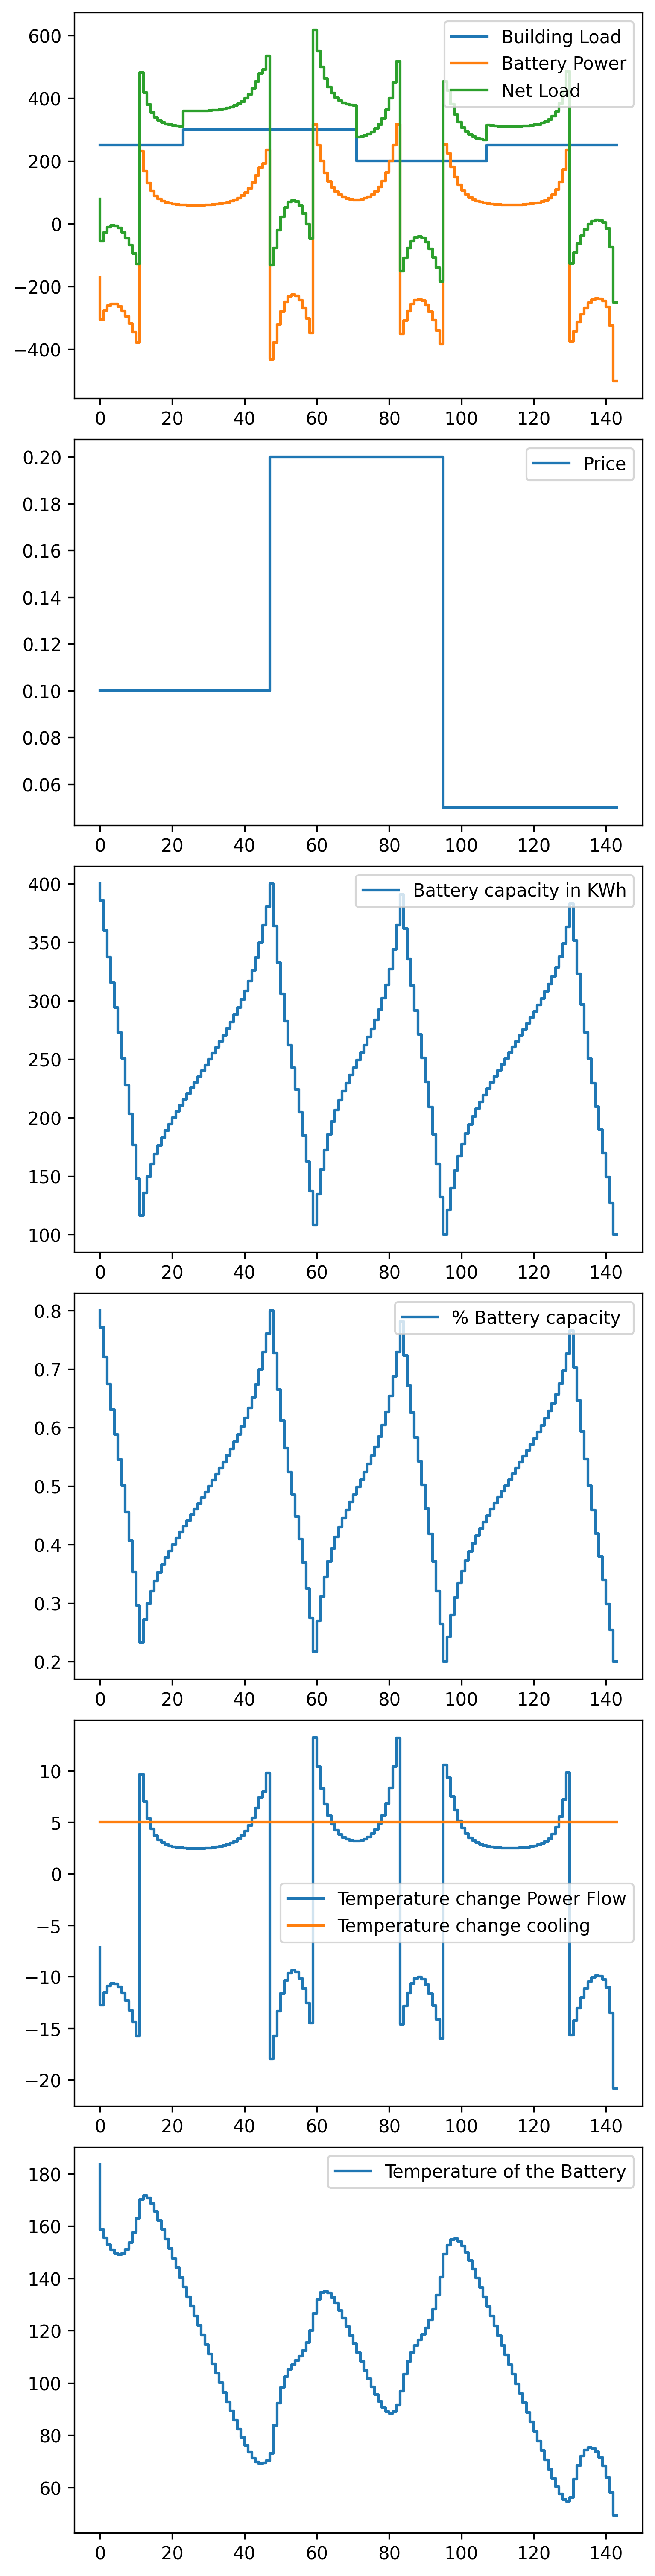

In [ ]:
# Define the time horizon and control interval for the battery model
opt_horizon = 144
opt_control_interval_h = 1 / 12

# Define the electricity price over the time horizon
price = np.array([0.1] * 48 + [0.2] * 48 + [0.05] * 48)

# Define the load profile of a building over the time horizon
building_load = np.array([250.0] * 24 + [300.0] * 48 + [200.0] * 36 + [250.0] * 36)

# Initialize an instance of the SimpleBatteryModel class with the specified parameters
batteryEX = ExtendedBatteryModel( horizon = opt_horizon,
                                control_interval_h = opt_control_interval_h,
                                discharge_limit_kw = 500.0,
                                charging_limit_kw = 500.0,
                                capacity_kwh = 500.0,        # battery capacity in kWh
                                soc_min = 0.2,                # minimum SOC
                                soc_max = 0.8,                # maximum SOC
                                temperature_rise_C_kw  = 0.5,  # 0.5 deg C / kWh
                                cooling_disipation_C_min = 1.0,  # 1.0 deg C /minute
                                temperature_ambient = 25.0,     # 25.0 deg C
                                temperature_max  = 200.0        # 200.0 deg C
                            )


# Initialize an instance of the TimeOfUseTariff class to calculate the net cost of electricity
# for the building over the time horizon
tou_tariff = TimeOfUseTariff(price, batteryEX, building_load, opt_control_interval_h)
# Calculate the net cost of electricity using the TimeOfUseTariff object
cost = tou_tariff.net_cost()

# Get a list of the constraints defined by the battery object
constraints = batteryEX.constraints()

# Define an optimization problem to minimize the net cost of electricity subject to the constraints
problem = cp.Problem(objective=cp.Minimize(cost), constraints=constraints)

# Solve the optimization problem using the ECOS solver and print the optimal value of the objective function
problem.solve(verbose=True, solver="ECOS_BB")
print(problem.value)

# Plot the battery operation over the time horizon
plot(opt_horizon, building_load, batteryEX, price)

#### OPTION N°3

This formulation incorporates the non-linear behaviour of the cooling system.

In order to do that, a IF-THEN rule representing the step-like function of the cooling system is employed:
* If Temperature of the Battery > Ambient temperature THEN cooling_on = True.
* ELSE cooling_on = False.

This can be represented using two variable M1 and M2 that bound the difference between Temperature of the Battery and Ambient temperature.

-M1 +1 < Temperature of the Battery - Ambient temperature < M2.

which can be calculated from the temperature_max and temperature_min conditions.

In [ ]:
# Full version
class ExtendedBatteryModel:
    def __init__(
        self,
        horizon: int = 144,                  # 12 hours
        control_interval_h: float = 1 / 12,  # 5 minute control intervals
        discharge_limit_kw: float = 500.0,
        charging_limit_kw: float = 500.0,

        # SOC related parameters
        capacity_kwh: float = 500.0,        # battery capacity in kWh
        soc_min: float = 0.2,                # minimum SOC
        soc_max: float = 0.8,                # maximum SOC

        # Temperature related parameters
        temperature_rise_C_kw : float = 0.1,  # 0.1 deg C / kWh
        cooling_disipation_C_min: float = 1.0,  # 1.0 deg C /minute
        temperature_ambient : float = 25.0,     # 25.0 deg C
        temperature_max : float = 200.0,        # 200.0 deg C
    ):
        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Optimization model parameters
        self.horizon = horizon
        self.control_interval_h = control_interval_h

        # Battery parameters
        self.discharge_limit_kw = -discharge_limit_kw
        self.charging_limit_kw = charging_limit_kw

        # State of charge parameters 
        self.capacity_kwh = capacity_kwh
        self.soc_min = soc_min
        self.soc_max = soc_max

        # Temperature related parameters
        self.temperature_rise_C_kw = temperature_rise_C_kw
        self.cooling_disipation_C_min = cooling_disipation_C_min
        self.temperature_ambient = temperature_ambient
        self.temperature_max = temperature_max


        # CONVEX FORMULATION RELATED VARIABLES
        #---------------------------------------
        # power_kw is a variable which stores the power input/output of the battery
        # For this example, we consider that the battery is 100% efficient, so we don't need
        # to model charging and discharging separately.
        # In our model, charging is positive and discharging is negative.
        self.power_kw = cp.Variable((self.horizon,))


        # Define the CP. Variable related to the SOC of the Battery storage
        self.soc_kwh = cp.Variable((self.horizon,))

        # Define the CP. Variable related to the temperature of the Battery storage
        self.temperature_C = cp.Variable((self.horizon,))

        # Define the CP. Variable related to implementation of the 
        # absolute value constraints using big-M formulation
        self.N = 100000  # choose a large value for N
        self.Y = cp.Variable((self.horizon-1,),boolean=True)

        # Define the CP. Variables related to the model of the cooling system
        self.cooling_disipation = self.cooling_disipation_C_min * 60 * self.control_interval_h
        self.M2 = self.temperature_max - self.temperature_ambient
        self.M1 = - self.cooling_disipation
        self.cooling_on = cp.Variable((self.horizon-1,),boolean=True)


        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define constraints
        self.constr = []
        self.constr += [self.discharge_power_limit(),
                        self.charging_power_limit(),
                        self.min_capacity_limit(),
                        self.max_capacity_limit(),
                        self.soc_update(),
                        self.min_temperature_limit(),
                        self.max_temperature_limit()]

        # Cooling System on/iff constraints
        self.M1M2_contraints = []
        self.M1M2_contraints = self.cooling_on_constr()

        for constraint in self.M1M2_contraints:
          self.constr += [constraint]


        # Temperature Update constraints
        self.Big_M_contraints = []
        self.Big_M_contraints = self.temperature_update()

        for constraint in self.Big_M_contraints:
          self.constr += [constraint]




    def discharge_power_limit(self) -> cp.Constraint:
        """Limit the discharge power of the battery."""
        return self.power_kw >= self.discharge_limit_kw

    def charging_power_limit(self) -> cp.Constraint:
        """Limit the charging power of the battery."""
        return self.power_kw <= self.charging_limit_kw

    def max_capacity_limit(self):
        """Limit the maximum energy stored in the battery to be less than its capacity."""
        # TODO: This function should return a constraint which limits the total energy stored in
        #       the battery to less than the battery capacity at all times.
        return self.soc_kwh / self.capacity_kwh <= self.soc_max

    def min_capacity_limit(self):
        """Limit the energy stored in the battery to be greater than a minimum value."""
        # TODO: This function should return a constraint which limits the total energy stored in
        #       the battery to more than a minimum value at all times.
        return self.soc_kwh / self.capacity_kwh >= self.soc_min

    def soc_update(self):
        """Update the SOC of the battery based on the power input/output."""
        #As Soc is stored as KWh variable, the energy charged or discharged by power_kw 
        #from one sample to the following one should be expressed in  KWh.
        #And from one sample to the following one there is a delta t of 5 minutes or 1/12 hours
        
        # Calculate the change in SOC from one time interval to the next
        delta_soc = cp.diff(self.soc_kwh)

        # Calculate the energy charged or discharged by the battery in each time interval
        energy = self.power_kw[:-1] * self.control_interval_h

        # Combine the SOC change and energy into a single vector equation
        return delta_soc == energy  # THIS ARE EQUALLITY CONTRAINTS

    def max_temperature_limit(self):
        """
        Limit the maximum battery temperature to be 
        less than or equal to the maximum allowable temperature.
        """
        return self.temperature_C <= self.temperature_max

    def min_temperature_limit(self):
        """
        Limit the minimum battery temperature to be 
        greater than or equal to the ambient temperature.
        """
        '''
        NOTE:Since the cooling system cannot take the battery temperature
        below the ambient temperature, it is not physically possible
        for the battery temperature to be lower than the ambient temperature.
        Therefore, it makes sense to constrain the battery temperature to be
        greater than or equal to the ambient temperature, 
        rather than constraining it to be strictly greater than 
        the ambient temperature. 
        This avoids the need to model the cooling system's behavior
        for temperatures below the ambient temperature and simplifies
        the overall model.
        '''
        return self.temperature_C >= ( self.temperature_ambient )

    def cooling_on_constr (self):
        '''
        IF-THEN rule representing the step-like function of the cooling system is employed:
          * If Temperature of the Battery > Ambient temperature THEN cooling_on = True.
          * ELSE cooling_on = False.

        This can be represented using two variable M1 and M2 that bound the difference between Temperature of the Battery and Ambient temperature.

              -M1 +1 < Temperature of the Battery - Ambient temperature < M2.   
        '''
        contraints_cooling = [
            self.temperature_ambient-self.temperature_C[:-1] <= self.M1*(1-self.cooling_on)-1,
            self.temperature_C[:-1]-self.temperature_ambient <= self.M2*self.cooling_on
        ]
        
        return contraints_cooling


    def temperature_update(self):
        """
        
        Calculate the temperature change in each time interval

        This must be the difference between:
              (absolute value of self.power *  self.temperature_rise_C_kw)
              (self.cooling_disipation_C_min * 60 * self.control_interval_h )
        
        """
        # Calculate the change Battery´s temperature from one time interval to the next
        temperature_delta = cp.diff(self.temperature_C)

        # Calculate the temperature change due to cooling in each time interval
        temperature_change_cooling = (self.cooling_disipation) * self.cooling_on

        
        # Calculate the temperature change due to power flow in each time interval
        # NOTE THAT: temperature_change_power should be ALWAYS positive.
        # To Handle this condition, we cannnot use ABS() because that turns the problem non-convex.
        # So, we have to use another trick to model that condition.
        temperature_change_power = (self.power_kw[:-1]) * self.temperature_rise_C_kw * self.control_interval_h

        # Implement the absolute value constraints using big-M formulation
        constraints = [
             temperature_change_power <= temperature_delta + temperature_change_cooling,
            -temperature_change_power <= temperature_delta + temperature_change_cooling,
            temperature_change_power + self.N * self.Y >= temperature_delta + temperature_change_cooling,
            -temperature_change_power + self.N * (1 - self.Y) >= temperature_delta + temperature_change_cooling      
            ]

        return constraints 

    def constraints(self) -> List[cp.Constraint]:
        """Return list of constraints describing the battery model."""
        return self.constr

    def print_constraints(self):
      print(self.constr)
      return None

In [ ]:
# ExtendedBatteryModel inheriting from SimpleBattert model
class ExtendedBatteryModel(SimpleBatteryModel):
    def __init__(
        self,
        horizon: int = 144,
        control_interval_h: float = 1 / 12,
        discharge_limit_kw: float = 500.0,
        charging_limit_kw: float = 500.0,
        capacity_kwh: float = 500.0,
        soc_min: float = 0.2,
        soc_max: float = 0.8,
        temperature_rise_C_kw: float = 0.1,
        cooling_disipation_C_min: float = 1.0,
        temperature_ambient: float = 25.0,
        temperature_max: float = 200.0
    ):
        # Call the __init__ method of the SimpleBatteryModel class to initialize
        # the optimization model parameters and battery parameters
        super().__init__(
            horizon=horizon,
            control_interval_h=control_interval_h,
            capacity_kwh=capacity_kwh,
            discharge_limit_kw = discharge_limit_kw,
            charging_limit_kw = charging_limit_kw,
            soc_min = soc_min,
            soc_max = soc_max
        )
        
        # CONTEXTURAL VARIABLES
        #---------------------------------------

        # Temperature related parameters
        self.temperature_rise_C_kw = temperature_rise_C_kw
        self.cooling_disipation_C_min = cooling_disipation_C_min
        self.temperature_ambient = temperature_ambient
        self.temperature_max = temperature_max


        # CONTEXTURAL VARIABLES
        #---------------------------------------
        # Define the CP. Variable related to the temperature of the Battery storage
        self.temperature_C = cp.Variable((self.horizon,))

        # Define the CP. Variable related to implementation of the 
        # absolute value constraints using big-M formulation
        self.N = 100000  # choose a large value for N
        self.Y = cp.Variable((self.horizon-1,),boolean=True)

        # Define the CP. Variables related to the model of the cooling system
        self.cooling_disipation = self.cooling_disipation_C_min * 60 * self.control_interval_h
        self.M2 = self.temperature_max - self.temperature_ambient
        self.M1 = - self.cooling_disipation
        self.cooling_on = cp.Variable((self.horizon-1,),boolean=True)


        # CONVEX FORMULATION RELATED CONSTRAINTS
        #---------------------------------------
        # Define constraints
        self.constr += [
                        self.min_temperature_limit(),
                        self.max_temperature_limit()]

        # Cooling System on/iff constraints
        self.M1M2_contraints = []
        self.M1M2_contraints = self.cooling_on_constr()

        for constraint in self.M1M2_contraints:
          self.constr += [constraint]


        # Temperature Update constraints
        self.Big_M_contraints = []
        self.Big_M_contraints = self.temperature_update()

        for constraint in self.Big_M_contraints:
          self.constr += [constraint]


    def max_temperature_limit(self):
        """
        Limit the maximum battery temperature to be 
        less than or equal to the maximum allowable temperature.
        """
        return self.temperature_C <= self.temperature_max

    def min_temperature_limit(self):
        """
        Limit the minimum battery temperature to be 
        greater than or equal to the ambient temperature.
        """
        '''
        NOTE:Since the cooling system cannot take the battery temperature
        below the ambient temperature, it is not physically possible
        for the battery temperature to be lower than the ambient temperature.
        Therefore, it makes sense to constrain the battery temperature to be
        greater than or equal to the ambient temperature, 
        rather than constraining it to be strictly greater than 
        the ambient temperature. 
        This avoids the need to model the cooling system's behavior
        for temperatures below the ambient temperature and simplifies
        the overall model.
        '''
        return self.temperature_C >= (0.0*self.temperature_ambient )

    def cooling_on_constr (self):
        '''
        IF-THEN rule representing the step-like function of the cooling system is employed:
          * If Temperature of the Battery > Ambient temperature THEN cooling_on = True.
          * ELSE cooling_on = False.

        This can be represented using two variable M1 and M2 that bound the difference between Temperature of the Battery and Ambient temperature.

              -M1 +1 < Temperature of the Battery - Ambient temperature < M2.   
        '''
        contraints_cooling = [
            self.temperature_ambient-self.temperature_C[:-1] <= self.M1*(1-self.cooling_on)-1,
            self.temperature_C[:-1]-self.temperature_ambient <= self.M2*self.cooling_on
        ]
        
        return contraints_cooling


    def temperature_update(self):
        """
        
        Calculate the temperature change in each time interval

        This must be the difference between:
              (absolute value of self.power *  self.temperature_rise_C_kw)
              (self.cooling_disipation_C_min * 60 * self.control_interval_h )
        
        """
        # Calculate the change Battery´s temperature from one time interval to the next
        temperature_delta = cp.diff(self.temperature_C)

        # Calculate the temperature change due to cooling in each time interval
        temperature_change_cooling = (self.cooling_disipation) * self.cooling_on

        
        # Calculate the temperature change due to power flow in each time interval
        # NOTE THAT: temperature_change_power should be ALWAYS positive.
        # To Handle this condition, we cannnot use ABS() because that turns the problem non-convex.
        # So, we have to use another trick to model that condition.
        temperature_change_power = (self.power_kw[:-1]) * self.temperature_rise_C_kw * self.control_interval_h

        # Implement the absolute value constraints using big-M formulation
        constraints = [
             temperature_change_power <= temperature_delta + temperature_change_cooling,
            -temperature_change_power <= temperature_delta + temperature_change_cooling,
            temperature_change_power + self.N * self.Y >= temperature_delta + temperature_change_cooling,
            -temperature_change_power + self.N * (1 - self.Y) >= temperature_delta + temperature_change_cooling      
            ]

        return constraints 



### 3.2 Cost Function and Plotting


In [ ]:
class TimeOfUseTariff:
    """Model of a time-varying tariff"""

    def __init__(
        self,
        price_usd_kwh: np.ndarray,
        battery: SimpleBatteryModel,
        building_load_kw: np.ndarray,
        control_interval_h: float,
    ):
        self.price_usd_kwh = price_usd_kwh
        self.battery = battery
        self.building_load_kw = building_load_kw
        self.control_interval_h = control_interval_h

    def net_cost(self) -> cp.Expression:
        """Return the cost/revenue of the battery and building load."""
        
        ''' 
        This cost function has to defined as following:
          It has to be sum of the energy costs at each time instant
          The energy cost at each instant is ( P_load + P_battery)*price*delt_t
          When the battery is charging the P_battery is positive, therefore, it is acting as another load
          Viceverse when the battery is discharging.
          And we have to conver all the power flow from kw to kwH to consider the different prices of the energy
        '''

        '''
        In this implementation, we calculate the energy cost at each time interval as the product of
        the time-varying price vector, the sum of the building load and battery power output/input, 
        and the control interval time.
        The building load and battery power are summed because they represent the total power
        consumption or generation at each time interval.

        Note that we convert the power units from kW to kWh by multiplying by the control interval time
        (in hours). This is necessary because the time-varying price vector is defined in units of $/kWh.

        Finally, we sum the energy costs over the time horizon to obtain the total cost/revenue.
        '''

        # Calculate the energy cost at each time interval
        energy_cost = cp.multiply(self.price_usd_kwh, (self.building_load_kw + self.battery.power_kw) * self.control_interval_h)
        # Calculate the total cost/revenue
        total_cost = cp.sum(energy_cost)
        
        return total_cost


def plot(horizon: int, building_load: np.ndarray, battery: SimpleBatteryModel, price: np.ndarray):
    """Plot the results of the optimization."""
    fig, ax = plt.subplots( nrows=6,
                            ncols=1,
                            figsize=(5, 20),
                            layout='constrained',
                            dpi=300)
    x = np.arange(horizon)
    ax[0].step(x, building_load, label="Building Load")
    ax[0].step(x, battery.power_kw.value, label="Battery Power")
    ax[0].step(x, building_load + battery.power_kw.value, label="Net Load")
    ax[0].legend()
    ax[1].step(x, price, label="Price")
    ax[1].legend()
    ax[2].step(x, battery.soc_kwh.value, label = 'Battery capacity in KWh')
    ax[2].legend()
    ax[3].step(x, (battery.soc_kwh.value/battery.capacity_kwh), label = '% Battery capacity ')
    ax[3].legend()
    ax[4].step(x, (battery.power_kw.value * battery.temperature_rise_C_kw * battery.control_interval_h), label = 'Temperature change Power Flow')
    ax[4].legend()
    ax[5].step(x, (battery.temperature_C.value), label = 'Temperature of the Battery')
    ax[5].legend()
    plt.show()

Promote(25.0, (143,)) + -var2222[0:143] <= Promote(-5.0, (143,)) @ (Promote(1.0, (143,)) + -var2224) + Promote(-1.0, (143,))
var2222[0:143] + Promote(-25.0, (143,)) <= Promote(175.0, (143,)) @ var2224
var2185[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) <= var2222[1:144] + -var2222[0:143] + Promote(5.0, (143,)) @ var2224
-var2185[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) <= var2222[1:144] + -var2222[0:143] + Promote(5.0, (143,)) @ var2224
var2222[1:144] + -var2222[0:143] + Promote(5.0, (143,)) @ var2224 <= var2185[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) + Promote(100000.0, (143,)) @ var2223
var2222[1:144] + -var2222[0:143] + Promote(5.0, (143,)) @ var2224 <= -var2185[0:143] @ Promote(0.5, (143,)) @ Promote(0.08333333333333333, (143,)) + Promote(100000.0, (143,)) @ (Promote(1.0, (143,)) + -var2223)
                                     CVXPY                                     
                               

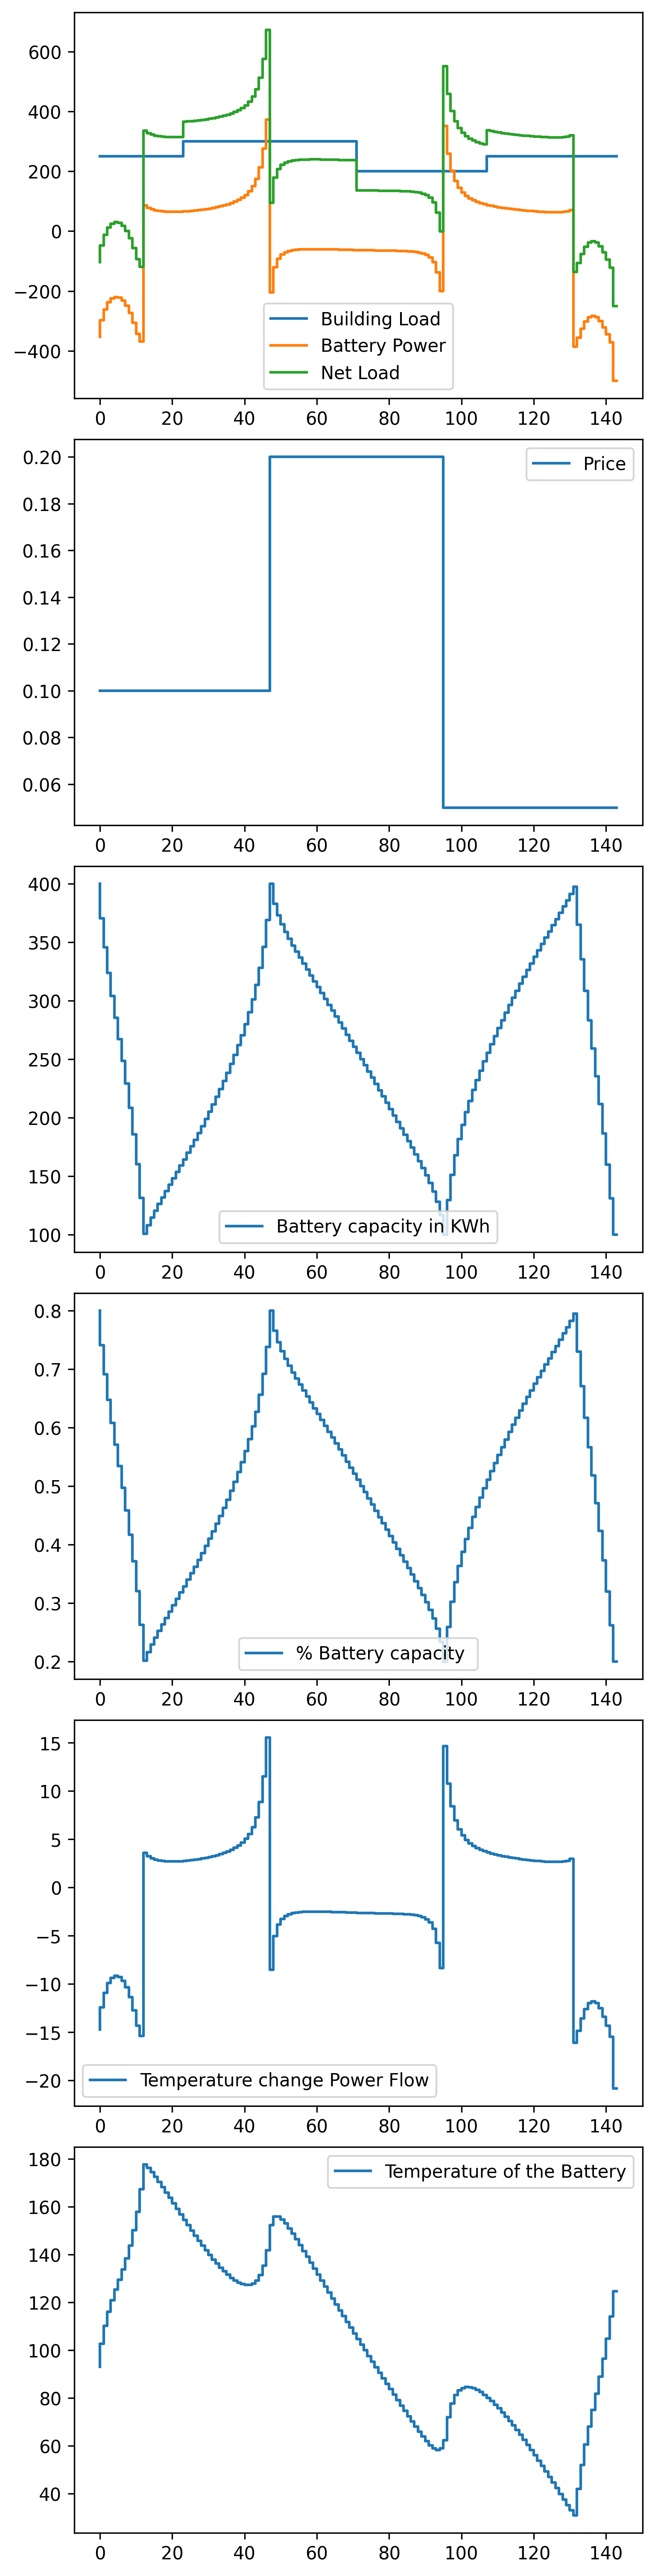

In [ ]:
# Define the time horizon and control interval for the battery model
opt_horizon = 144
opt_control_interval_h = 1 / 12

# Define the electricity price over the time horizon
price = np.array([0.1] * 48 + [0.2] * 48 + [0.05] * 48)

# Define the load profile of a building over the time horizon
building_load = np.array([250.0] * 24 + [300.0] * 48 + [200.0] * 36 + [250.0] * 36)

# Initialize an instance of the SimpleBatteryModel class with the specified parameters
batteryEX = ExtendedBatteryModel( horizon = opt_horizon,
                                control_interval_h = opt_control_interval_h,
                                discharge_limit_kw = 500.0,
                                charging_limit_kw = 500.0,
                                capacity_kwh = 500.0,        # battery capacity in kWh
                                soc_min = 0.2,                # minimum SOC
                                soc_max = 0.8,                # maximum SOC
                                temperature_rise_C_kw  = 0.5,  # 0.5 deg C / kWh
                                cooling_disipation_C_min = 1.0,  # 1.0 deg C /minute
                                temperature_ambient = 25.0,     # 25.0 deg C
                                temperature_max  = 200.0        # 200.0 deg C
                            )


# Initialize an instance of the TimeOfUseTariff class to calculate the net cost of electricity
# for the building over the time horizon
tou_tariff = TimeOfUseTariff(price, batteryEX, building_load, opt_control_interval_h)
# Calculate the net cost of electricity using the TimeOfUseTariff object
cost = tou_tariff.net_cost()

# Get a list of the constraints defined by the battery object
constraints = batteryEX.constraints()

# Define an optimization problem to minimize the net cost of electricity subject to the constraints
problem = cp.Problem(objective=cp.Minimize(cost), constraints=constraints)

# Solve the optimization problem using the ECOS solver and print the optimal value of the objective function
problem.solve(verbose=True, solver="ECOS_BB")
print(problem.value)

# Plot the battery operation over the time horizon
plot(opt_horizon, building_load, batteryEX, price)


### 3.3 Conclusion

After considering the above mentioned 3 possible approaches to the extended battery model, some observations could be made:

* None of the three methods are able to deal with the situation where the temperature change due to power flow is small compared to the cooling action. However, in such a scenario, incorporating temperature constraints into the optimization problem may not be necessary unless there is a cost associated with the cooling system, such as an active cooling system rather than just convection with air. In that case, the cooling action would be incorporated into the cost function with a term related to minimizing the cost associated with cooling the battery.
* Based on the above, if the cooling system has no associated cost, then OPTION 2 would be the better option as it keeps the battery colder for the same load scenario, and its formulation is simpler than those of OPTIONS 1 and 3. However, if the cooling system's operation should be tracked, then OPTION 3 is the only viable option, given that it is the only one that models the on/off nature of the cooling system.